In [19]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import numpy as np

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])
training_data, test_data = torch.utils.data.random_split(training_data, [40000, 10000])
train_dataloader = DataLoader(training_data, batch_size=64)
validation_dataloader = DataLoader(validation_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)


Using cpu device


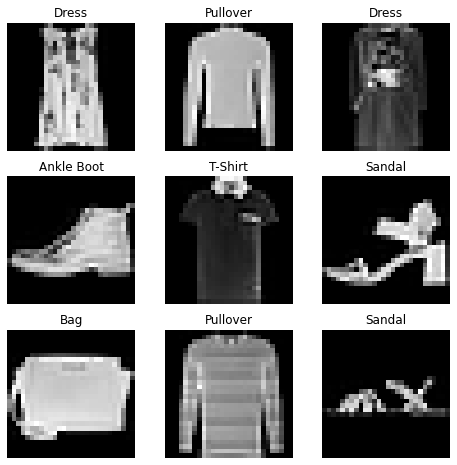

In [20]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self,n_neurons=512,input_dim=28*28,output_dim=10):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, output_dim),
            
        )
        #self.softmax=nn.Softmax()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        #output=self.softmax(x)  Softmax is not needed only because pytorch does this with cross entropy loss automatically
        return x

In [22]:
learning_rate = 1e-3
batch_size = 64
epochs = 10
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

In [23]:
def fit_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"loss: {loss}  [{current}/{size}]")


def predict_dataset(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Error: \n Accuracy: {(100*correct)}%, Avg loss: {test_loss} \n")
    return 100*correct

def predict(data,model,apply_softmax=True):
    labels=data[1]
    label=labels[0] #Take first element of batch
    data=data[0]  
    data=data[0,:,:,:] #Take first element of batch
    print(f"Size of one sample is {data.size()}") #First dimension is 1 because image is black & white. Would be 3 for RGB.
    pred = model(data)
    if apply_softmax:
        softmax=nn.Softmax()
        pred=softmax(pred)
    pred=pred.detach().numpy()
    pred=pred[0]
    print(f"Predicted label probabilities for first image: {pred*100}")
    print(f"True label for first image is {label.numpy()}")

In [24]:
weight_decays = [0.000001,0.00001,0.0001,0.001,0.1]
n_neurons = [200,450,700,950,1200]
acc_neurons = []
acc_neurons_test = []

for neuron in n_neurons:
  for weight_d in weight_decays:
    acc = 0
    acc_act = 0
    print(f"Neurons: {neuron}, Weight decay: {weight_d}")
    model = NeuralNetwork(n_neurons=neuron)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_d)

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        fit_one_epoch(train_dataloader, model, loss_fn, optimizer)
        print('Validation results:')
        acc_val = predict_dataset(validation_dataloader, model, loss_fn)
        if acc_val > acc:
          acc = acc_val
    
    acc_neurons.append((neuron,weight_d,acc));

    print('Test results:')
    predict(next(iter(test_dataloader)),model,loss_fn)
    acc_test = predict_dataset(test_dataloader, model, loss_fn)
    acc_neurons_test.append((neuron,weight_d,acc_test));

best_acc = 0
best_ind = 0
for i in range(0,len(acc_neurons)):
  if acc_neurons[i][2] > best_acc:
    best_acc = acc_neurons[i][2]
    best_ind = i
print(f"Best validation accuracy: {best_acc} with neurons: {acc_neurons[best_ind][0]} and weight decay: {acc_neurons[best_ind][1]}")

best_acc_test = 0
best_ind_test = 0
for i in range(0,len(acc_neurons_test)):
  if acc_neurons_test[i][2] > best_acc_test:
    best_acc_test = acc_neurons_test[i][2]
    best_ind_test = i
print(f"Best test accuracy: {best_acc_test} with neurons: {acc_neurons_test[best_ind_test][0]} and weight decay: {acc_neurons_test[best_ind_test][1]}")

Neurons: 200, Weight decay: 1e-06
Epoch 1
-------------------------------
Validation results:
Error: 
 Accuracy: 39.83%, Avg loss: 2.240686381698414 

Epoch 2
-------------------------------
Validation results:
Error: 
 Accuracy: 45.5%, Avg loss: 2.157581046888023 

Epoch 3
-------------------------------
Validation results:
Error: 
 Accuracy: 52.76%, Avg loss: 2.0254219975441123 

Epoch 4
-------------------------------
Validation results:
Error: 
 Accuracy: 58.720000000000006%, Avg loss: 1.831023476685688 

Epoch 5
-------------------------------
Validation results:
Error: 
 Accuracy: 59.43000000000001%, Avg loss: 1.5979579330249956 

Epoch 6
-------------------------------
Validation results:
Error: 
 Accuracy: 60.62%, Avg loss: 1.392828462989467 

Epoch 7
-------------------------------
Validation results:
Error: 
 Accuracy: 62.17%, Avg loss: 1.238866588112655 

Epoch 8
-------------------------------
Validation results:
Error: 
 Accuracy: 63.739999999999995%, Avg loss: 1.125644341

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Error: 
 Accuracy: 65.82000000000001%, Avg loss: 0.9968084859999882 

Neurons: 200, Weight decay: 1e-05
Epoch 1
-------------------------------
Validation results:
Error: 
 Accuracy: 23.75%, Avg loss: 2.2466520397526444 

Epoch 2
-------------------------------
Validation results:
Error: 
 Accuracy: 34.2%, Avg loss: 2.169355062922095 

Epoch 3
-------------------------------
Validation results:
Error: 
 Accuracy: 47.33%, Avg loss: 2.0423713664340366 

Epoch 4
-------------------------------
Validation results:
Error: 
 Accuracy: 55.230000000000004%, Avg loss: 1.8466298777586336 

Epoch 5
-------------------------------
Validation results:
Error: 
 Accuracy: 60.72%, Avg loss: 1.6141405606725414 

Epoch 6
-------------------------------
Validation results:
Error: 
 Accuracy: 62.949999999999996%, Avg loss: 1.4025268471165069 

Epoch 7
-------------------------------
Validation results:
Error: 
 Accuracy: 63.88%, Avg loss: 1.237924177935169 

Epoch 8
-------------------------------
Validat

Overall, the test accuracy gets better with more neurons but with lower weight decay. Within the same number of neurons higher weight decay yields lower accuracy usually.

* Neurons: 200, Weight decay: 1e-06
 Accuracy: 65.82000000000001%

* Neurons: 200, Weight decay: 1e-05
 Accuracy: 66.73%

* Neurons: 200, Weight decay: 0.0001
 Accuracy: 64.3%

* Neurons: 200, Weight decay: 0.001
 Accuracy: 66.29%

* Neurons: 200, Weight decay: 0.1
 Accuracy: 50.51%

* Neurons: 450, Weight decay: 1e-06
 Accuracy: 67.92%

* Neurons: 450, Weight decay: 1e-05
 Accuracy: 67.75%

* Neurons: 450, Weight decay: 0.0001
 Accuracy: 67.86%

* Neurons: 450, Weight decay: 0.001
 Accuracy: 67.53%

* Neurons: 450, Weight decay: 0.1
 Accuracy: 55.33%

* Neurons: 700, Weight decay: 1e-06
 Accuracy: 68.7%

* Neurons: 700, Weight decay: 1e-05
 Accuracy: 68.97%

* Neurons: 700, Weight decay: 0.0001
 Accuracy: 68.52000000000001%

* Neurons: 700, Weight decay: 0.001
 Accuracy: 68.28999999999999%

* Neurons: 700, Weight decay: 0.1
 Accuracy: 58.85%

* Neurons: 950, Weight decay: 1e-06
 Accuracy: 68.78999999999999%

* Neurons: 950, Weight decay: 1e-05
 Accuracy: 69.19%

* Neurons: 950, Weight decay: 0.0001
 Accuracy: 69.08%

* Neurons: 950, Weight decay: 0.001
 Accuracy: 69.16%

* Neurons: 950, Weight decay: 0.1 
 Accuracy: 60.480000000000004%

* Neurons: 1200, Weight decay: 1e-06 
 Accuracy: 70.52000000000001%

* Neurons: 1200, Weight decay: 1e-05
 Accuracy: 70.39999999999999% 

* Neurons: 1200, Weight decay: 0.0001
 Accuracy: 70.13000000000001% 

* Neurons: 1200, Weight decay: 0.001
 Accuracy: 69.89%

* Neurons: 1200, Weight decay: 0.1
 Accuracy: 61.25000000000001%